## Deep Learning Models

The _objectives_ in the following `Notebook` are:

1. Use and generate <code style="background:yellow;color:black">embedding feature </code> in raw text for sentiment analysis
2. Try out different types of __embedding file__ and check for results and accuracy
3. Look for best <code style="background:yellow;color:black">possible accuracy </code> and do a error analysis on the results of the model.


In [1]:
# Pip install dependencies if missing
# Libraries
import pandas as pd
import numpy as np
import os
from termcolor import colored
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import class_weight
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.python.client import device_lib
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Reading in proper format from our mentioned file
df_train = pd.read_pickle('train_features.pkl')
df_test  = pd.read_pickle('test_features.pkl')

## Introduction

*Enter the dark world of deep learning....*

1. In this approach we extensively use LSTM and embedding approach to generate feature representation and classification

2. Although for tokenizing we will use Kera's **tokenizer** for feature space embedding we will use a pre-trained word vectors which we can download  from listed sources

3. We take 3 approaches to train our model for **sentiment classification** task which are listed as below:


> **Keras Word embedding + LSTM**: In this simple approach we use the Keras embedding layer in vector space representation and then train the model for accuracy using LSTM and dense networks.


> ** Glove-based embedding + LSTM** : In this modeling, we use pre-trained word vector embedding which we have obtained from this [stanford site](https://nlp.stanford.edu/projects/glove/). This contains words in '1B' tokens in '300d' vector space. We further use a bidirectional LSTM based approach to train our model for better accuracy and score.


> **Fast Text embedding + LSTM** : Another type of embedding use here is fast text embedding which can be found [fast text website](https://fasttext.cc/docs/en/english-vectors.html). This contains words in '6B' tokens in '1M' vector space. We aim to improve higher accuracy and less overfitting in this model using the same approach.










**Note:** Both the file size are too large the given link can be helpful for embedding purpose

**GloVE :** [glove.6B.300d.txt](https://nlp.stanford.edu/projects/glove/)

**Fast Text :** ['wiki-news-300d-1M.vec'](https://fasttext.cc/docs/en/english-vectors.html)

## Data Preparation

For the data preparation purpose into we use the following function which generates embeddings as well as uses our generated features(normalized) for the purpose of modelling

<div class="alert alert-block alert-info">
<b>Data Balance:</b> We see our data is not at all balanced. For this purpose we specifically assign weights to our corresponding labels. We do so, by giving higher weight to labels having low frequency and lower to labels having more frequency.</div>

In [3]:
## compute class weight
class_weight = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train.label), df_train.label)
class_weight = dict(enumerate(class_weight))

In [4]:
'''
Info:
1. Takes in train and test dataframe as input
2. Generates tokens with the the help of keras tokenizer function with the help of vocab size
3. Uses "word_index" count only if specified True in argument
4. Tokenises and returns word_index as "dict" only if called else the same variable is returned as boolean vaule
NOTE: The variable "word_index" is overwritten from bool to dict
5. Tokenizes train and test on the word text
6. Padding done to max sequence length which is by default 100 i.e we assume highest word in a sent of IMDB review is 100
7. Generates labels in proper format 
8. Normalization is done on 'other features' which we have generated before to be added into embedding layer
9. Returns 'X_train,y_train, X_test, y_test' in the form of numpy arrays
'''


def generate_lstm_features(df_train, df_test, max_features = 50000 , max_seq_length = 100, word_index = False):
   
    # Initialise the tokenizer with max vocab size by default 5000 and specify too
    tokenizer = Tokenizer(nb_words=max_features, split=' ')
    
    ### Feature mapping into tokens for train and test###
    # Fit into text to generate tokens
    tokenizer.fit_on_texts(df_train['Text'].values)
    # Generate tokens in sequences on each word of sent
    X_train = tokenizer.texts_to_sequences(df_train['Text'].values)
    # Generate labels into each expaded dimesnion
    y_train =  np.expand_dims(df_train['label'].astype(int).values, -1)
    
    # Word index required for pretrained word vectors like Glove and fast text
    if word_index:
        word_index = tokenizer.word_index
        print('Found %s unique tokens.' % len(word_index))
    
    # Same for test set
    X_test  = tokenizer.texts_to_sequences(df_test['Text'].values)
    y_test  =  np.expand_dims(df_test['label'].astype(int).values, -1)

    # Apdding the sequnce in max sequnce length i.e snetence length which in our case we take to be default 100
    X_train = sequence.pad_sequences(X_train, maxlen=max_seq_length)
    X_test  = sequence.pad_sequences(X_test,  maxlen=max_seq_length)
    
    # Drop columns
    X =  df_train.drop(columns = ['label', 'Text']).values
    y =  df_test.drop (columns = ['label', 'Text']).values

    # Normalsie the other features for bringing them into proper range                 
    scaler  = MinMaxScaler()
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y)
    
    # Concatenate them into proper numpy format to return the values
    X_train = np.concatenate((X,X_train), axis = 1)
    X_test  = np.concatenate((y, X_test), axis = 1)
    
    return X_train,y_train, X_test, y_test,word_index

In [5]:
'''
Info:
1. This function takes in the file of embedding with the dict "word_index" which gives index of each word and word 
2. This function generates embedding with the help of specified embedding file in our case Glove or FastText
3. It returns embedding matrix along with with embedding of each word in our specified vector length of 'embedding_size'

'''
def generate_embedding(embedding_file, EMBEDDING_SIZE, word_index):
    # For index dict
    embeddings_index = {}

    # Open the embedded file
    f = open(embedding_file, encoding="utf8")
    # Iterate in each line
    for line in f:
        values = line.split()
        word = values[0]
        # Try to get the embedding
        try:
          coefs = np.asarray(values[1:], dtype='float32')
          embeddings_index[word] = coefs
        # If not then pass
        except:
            pass
    # Close the file forsaving RAM and i/o
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))

    # Generate embedding in our specified size
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_SIZE))

    # For each word in our corpus get embeddings
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        # words not found in embedding index will be all-zeros.
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = 0

    return embedding_matrix

In [6]:
def display_history(history):
    """Summarize history for accuracy and loss.
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    

For plotting confusion matrix and watching the other metrics

## Keras Word embedding + LSTM

*Let's define some heuristics for our neural network model*

In [7]:
# Specify LSTM size
LSTM_CELL_SIZE  = 64
# Specify batch size
BATCH_SIZE      = 512
# LSTM tends to overfit so better for small EPOCHS
EPOCHS          = 5
# To avoid overfitting
DROPOUT_RATE    = 0.5
# Define Embedding size
EMBEDDING_SIZE  = 64
# This is the vocab of trained words in our network
MAX_FEATURES    = 50000
# Dense layer to be trained in network
DENSE_LAYER     = 32

In [8]:
# Let's generate our features accordingly
X_train, y_train, X_test, y_test,_ = generate_lstm_features(df_train, df_test, max_features = MAX_FEATURES , max_seq_length = 200)

In [10]:
# Reset the graph
be.clear_session()

# NOTE: We are using sequential
model = Sequential()

### create and fit the LSTM network ###

# Embedding layer with features and input length
model.add(Embedding(MAX_FEATURES + 1, EMBEDDING_SIZE, input_length = X_train.shape[1] ,mask_zero=True))

# Spatial Dropout layer  promote independence between feature maps
model.add(SpatialDropout1D(DROPOUT_RATE))

# One layer LSTM with params and regularization and intialization
model.add(LSTM(LSTM_CELL_SIZE,activation='tanh',kernel_regularizer=l1(0.001), recurrent_dropout=DROPOUT_RATE, dropout=DROPOUT_RATE ))

# Dense layer added with dropout 
model.add(Dense(DENSE_LAYER,activation = 'tanh',kernel_regularizer=l1(0.001), bias_initializer='he_uniform'))
model.add(Dropout(DROPOUT_RATE))

# Prediction layer with 'sigmoid' activation for binary classification
model.add(Dense(1,activation='sigmoid'))

# Compliling using 'BCE'  with Adam and accuracy as metric
model.compile(loss = 'binary_crossentropy', optimizer=Adam(lr=0.001), metrics = ['accuracy'])
model.summary()
plot_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 215, 64)           3200064   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 215, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,235,201
Trainable params: 3,235,201
Non-trainable params: 0
______________________________________________

In [11]:
%%time
history = model.fit(X_train, y_train,epochs=EPOCHS, batch_size=BATCH_SIZE,  validation_data = (X_test, y_test),class_weight = class_weight)  

Epoch 1/5
102/102 [==============================] - 309s 3s/step - loss: 1.6204 - accuracy: 0.6275 - val_loss: 0.8046 - val_accuracy: 0.7089
Epoch 2/5
102/102 [==============================] - 320s 3s/step - loss: 0.5275 - accuracy: 0.8693 - val_loss: 0.6182 - val_accuracy: 0.7248
Epoch 3/5
102/102 [==============================] - 335s 3s/step - loss: 0.3707 - accuracy: 0.8997 - val_loss: 0.5753 - val_accuracy: 0.7427
Epoch 4/5
102/102 [==============================] - 333s 3s/step - loss: 0.3164 - accuracy: 0.9156 - val_loss: 0.5783 - val_accuracy: 0.7469
Epoch 5/5
102/102 [==============================] - 362s 4s/step - loss: 0.2775 - accuracy: 0.9255 - val_loss: 0.5578 - val_accuracy: 0.7596
Wall time: 27min 37s


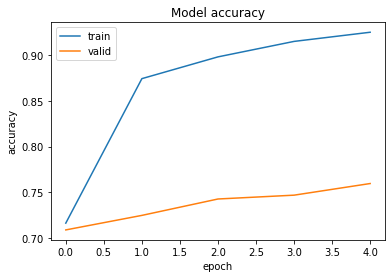

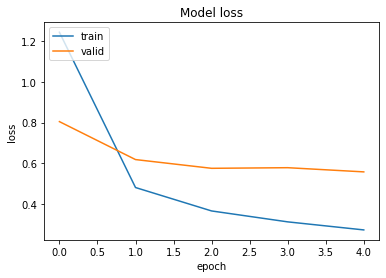

In [12]:
display_history(history)

*Observations*

<div class="alert alert-block alert-warning">

Here the model performs suprsingly well without pretrained vectors with proper feature selection but tends to overfit.
    
</div>

## Glove based embedding + LSTM

As discussed above we will be using pretrained embeddings in this case though in the architecture we use bi-directional LSTM

In [13]:
X_train, y_train, X_test, y_test, word_index = generate_lstm_features(df_train, df_test, word_index = True)

Found 50641 unique tokens.


In [17]:
# Same as above
LSTM_CELL_SIZE  = 64
BATCH_SIZE      = 1024
EPOCHS          = 3
DROPOUT_RATE    = 0.5

## Embeddding size of our Glove Vector is 300
EMBEDDING_SIZE  = 300

# We use it as found word index in the tokenisation process
MAX_FEATURES    = len(word_index) +  1
DENSE_LAYER     = 256

Time to do embedding with the found word_index in the corpus

In [18]:
%%time
# Let's use Glove Embedding
embedding_matrix = generate_embedding(embedding_file = 'glove.6B.300d.txt' ,EMBEDDING_SIZE  =  EMBEDDING_SIZE, word_index = word_index)

Found 400000 word vectors.
Wall time: 41.5 s


In [19]:
# Reset the graph
be.clear_session()

# NOTE: We are using sequential
model = Sequential()

# For early callback and model checkpoint

### create and fit the LSTM network ###

# Embedding layer with features and input length along with embedding matrix as weights
model.add(Embedding(MAX_FEATURES, EMBEDDING_SIZE,  weights=[embedding_matrix],  input_length = X_train.shape[1], trainable = True, mask_zero = True))

# Spatial Dropout layer  promote independence between feature maps
model.add(SpatialDropout1D(DROPOUT_RATE))

# One layer Bidirectional LSTM with params and regularization and intialization
model.add(LSTM(LSTM_CELL_SIZE,activation='tanh',kernel_regularizer=l1(0.001), recurrent_dropout=DROPOUT_RATE, dropout=DROPOUT_RATE ))

# Dense layer added with dropout 
model.add(Dense(DENSE_LAYER,activation = 'tanh',kernel_regularizer=l1(0.001), bias_initializer='he_uniform'))
model.add(Dropout(DROPOUT_RATE))

# Prediction layer with 'sigmoid' activation for binary classification
model.add(Dense(1,activation='sigmoid'))

# Compliling using 'BCE'  with Adam and accuracy as metric
model.compile(loss = 'binary_crossentropy', optimizer=Adam(lr=0.01), metrics = ['accuracy'])
model.summary()
plot_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 115, 300)          15192600  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 115, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 15,302,937
Trainable params: 15,302,937
Non-trainable params: 0
____________________________________________

In [20]:
%%time
history = model.fit(X_train, y_train,epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data = (X_test, y_test),class_weight = class_weight)  

Epoch 1/3
51/51 [==============================] - 100s 2s/step - loss: 2.4210 - accuracy: 0.7064 - val_loss: 0.7963 - val_accuracy: 0.7428
Epoch 2/3
51/51 [==============================] - 93s 2s/step - loss: 0.5790 - accuracy: 0.8700 - val_loss: 0.7210 - val_accuracy: 0.7709
Epoch 3/3
51/51 [==============================] - 95s 2s/step - loss: 0.4603 - accuracy: 0.9077 - val_loss: 0.6997 - val_accuracy: 0.7821
Wall time: 4min 48s


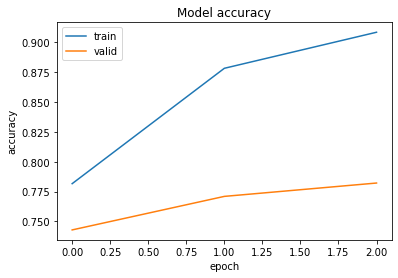

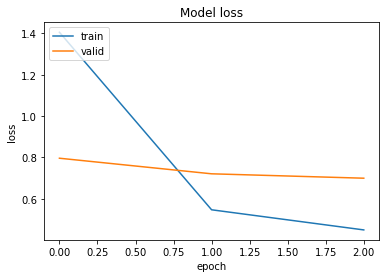

In [21]:
display_history(history)

*Observations*

<div class="alert alert-block alert-warning">

The model performs better in terms of results with trained embeddings and we also mitigate the problem of __'overfitting'__ in this case.
    
</div>

## Fast Text based embedding + LSTM

As discussed above we will be using pretrained embeddings in this case though in the architecture we use bi-directional LSTM

In [25]:
# Same as above
LSTM_CELL_SIZE  = 128
BATCH_SIZE      = 512
EPOCHS          = 5
DROPOUT_RATE    = 0.5

## Embedding size of our FAST-TEXT Vector is 300
EMBEDDING_SIZE  = 300

# We use it as found word index in the tokenisation process
MAX_FEATURES    = len(word_index) +  1
DENSE_LAYER_1    = 128
DENSE_LAYER_2    = 64

In [26]:
%%time
# Let's use fast text Embedding
embedding_matrix = generate_embedding(embedding_file = 'wiki-news-300d-1M.vec',EMBEDDING_SIZE  =  EMBEDDING_SIZE, word_index = word_index)

Found 999995 word vectors.
Wall time: 1min 46s



<div class="alert alert-block alert-warning">

Note:  **different architecture** has been used here with one extra layer as embedding size is more.
    
</div>

In [27]:
# Reset the graph
be.clear_session()

# NOTE: We are using sequential
model = Sequential()

# For early callback and model checkpoint

### create and fit the LSTM network ###

# Embedding layer with features and input length
model.add(Embedding(MAX_FEATURES, EMBEDDING_SIZE, weights=[embedding_matrix], input_length = X_train.shape[1] ,mask_zero=True, trainable = True))

# Spatial Dropout layer  promote independence between feature maps
model.add(SpatialDropout1D(DROPOUT_RATE))

#  Bidirectional LSTM with params and regularization and intialization
model.add(LSTM(LSTM_CELL_SIZE,activation='tanh',kernel_regularizer=l1(0.001), recurrent_dropout=DROPOUT_RATE, dropout=DROPOUT_RATE ))

# Dense layer 1 added with dropout 
model.add(Dense(DENSE_LAYER,activation = 'tanh',kernel_regularizer=l1(0.001), bias_initializer='he_uniform'))
model.add(Dropout(DROPOUT_RATE))

# Dense layer 2 added with dropout
model.add(Dense(DENSE_LAYER,activation = 'tanh',kernel_regularizer=l1(0.001), bias_initializer='he_uniform'))
model.add(Dropout(DROPOUT_RATE))

# Prediction layer with 'sigmoid' activation for binary classification
model.add(Dense(1,activation='sigmoid'))

# Compliling using 'BCE'  with Adam and accuracy as metric
model.compile(loss = 'binary_crossentropy', optimizer=Adam(lr=0.001), metrics = ['accuracy'])
model.summary()
plot_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 115, 300)          15192600  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 115, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [28]:
%%time
history = model.fit(X_train, y_train,epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data = (X_test, y_test),class_weight = class_weight) 

Epoch 1/5
102/102 [==============================] - 224s 2s/step - loss: 8.2026 - accuracy: 0.6561 - val_loss: 1.1207 - val_accuracy: 0.6742
Epoch 2/5
102/102 [==============================] - 171s 2s/step - loss: 0.6873 - accuracy: 0.8599 - val_loss: 0.7091 - val_accuracy: 0.7267
Epoch 3/5
102/102 [==============================] - 172s 2s/step - loss: 0.4635 - accuracy: 0.8919 - val_loss: 0.6518 - val_accuracy: 0.7479
Epoch 4/5
102/102 [==============================] - 169s 2s/step - loss: 0.4113 - accuracy: 0.9040 - val_loss: 0.6343 - val_accuracy: 0.7538
Epoch 5/5
102/102 [==============================] - 169s 2s/step - loss: 0.3648 - accuracy: 0.9191 - val_loss: 0.6278 - val_accuracy: 0.7612
Wall time: 15min 4s


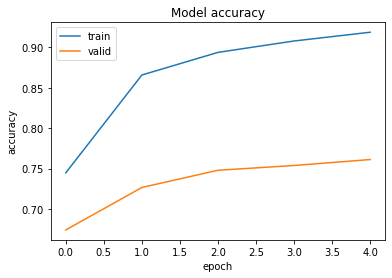

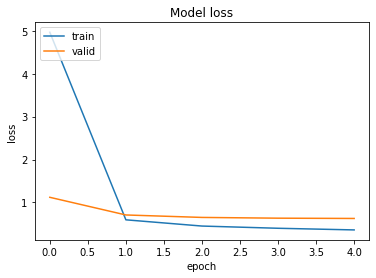

In [29]:
display_history(history)

*Observations*

<div class="alert alert-block alert-warning">
- Here the model performs considerably well only in training data than the former two in terms of loss as well as accuracy as the embedding size is large.

- But the problem, of overfitting, still remains even when extensive **regularization** is used.

- With more computational power comes good accuracy which is always a tradeoff to decided when training a model.
 
 *With great power comes great responsibilities*

    
</div>

## Conclusion

<div class="alert alert-block alert-success">
    
<b>Success:</b>
- With LSTM although we acheive good accuracy there is always a bottleneck in terms of overfitting 

- Let's now go to some pre-trained defined models and check their performance.
    
</div>
